In [1]:
import utils_general
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 4: MESM

##### Import MESM data

In [2]:
MESM_raw_path = '/Volumes/PRO-G40/data/raw/MESM2.2'
MESM_interim_path = '/Volumes/PRO-G40/data/interim/MESM2.2'
exp = '1pctCO2'

zonal_temp_path = f'{MESM_interim_path}/{exp}/temperature/zonal'
forcing_path = f'{MESM_raw_path}/{exp}/forcing'
global_temp_path = f'{MESM_raw_path}/temperature/global'


#### Preprocess zonal data to correct dates

In [12]:
import os
import pandas as pd
from collections import defaultdict
output_path = f'/Volumes/PRO-G40/data/interim/MESM2.2/{exp}/temperature/zonal'
os.makedirs(output_path, exist_ok=True)

# Generate the corrected time values
start_year = 1850

# Organize files by ensemble member
ensemble_files = defaultdict(list)
for file in sorted(os.listdir(zonal_temp_path)):
  if file.endswith(".nc"):
    # Extract the ensemble member from the file name
    ensemble_member = file.split(".")[2]  # The ensemble member is the third part of the filename
    ensemble_files[ensemble_member].append(file)

# Process each ensemble member
for ensemble_member, files in ensemble_files.items():
  datasets = []
  for i, file in enumerate(files):
    # Open the dataset
    ds = xr.open_dataset(os.path.join(zonal_temp_path, file))

    # Calculate the corrected time for this file
    year = start_year + i
    time_values = pd.date_range(start=f"{year}-01", periods=ds.sizes["time"], freq="MS")
    ds = ds.assign_coords(time=("time", time_values))

    # Append to the list of datasets
    datasets.append(ds)

  # Concatenate all datasets along the time dimension
  zonal_temp_ds = xr.concat(datasets, dim="time")

  # Save the concatenated dataset
  output_ds_path = os.path.join(output_path, f"ZONAL.1%-CO2.{ensemble_member}.nc")
  zonal_temp_ds.to_netcdf(output_ds_path)

In [3]:
zonal_temp_ds = xr.open_mfdataset(f'{zonal_temp_path}/ZONAL.1%-CO2.2001.nc')
forcing_ds = np.loadtxt(f'{forcing_path}/co2forasccitrop.1-150.2001.23', dtype=float, usecols=1, skiprows=1)

In [4]:
import utils_CMIP
zonal_temp_annual_ds = utils_CMIP.monthly_to_annual(zonal_temp_ds, 'DT2M')

In [66]:
def zonal_to_global(ds):
  weights = np.cos(np.deg2rad(ds.lat))
  weights.name = "weights"
  weighted = ds.weighted(weights)
  weighted_mean = weighted.mean(['lat'])

  return weighted_mean.as_numpy()

In [82]:
np.std(all_rzs[2])

1.489256206538972

In [107]:
rzs = [f'{i}' for i in range(2001,2202)]
st_dev = np.zeros(len(rzs))
all_rzs = []
for i, r in enumerate(rzs):
  zonal_temp_ds = xr.open_mfdataset(f'{zonal_temp_path}/ZONAL.1%-CO2.{r}.nc')
  zonal_temp_annual_ds = utils_CMIP.monthly_to_annual(zonal_temp_ds, 'DT2M')
  all_rzs.append(zonal_to_global(zonal_temp_annual_ds).values)
  avg = np.mean(all_rzs,axis=0)
  st_dev[i] = np.std(avg)

In [86]:
np.shape(all_rzs)

(101, 150)

In [119]:
import random
num_iterations = 40  # Number of random samplings

std_devs = []
for n in range(1,len(rzs)+1):
  std_devs_temp = []
  for _ in range(num_iterations):
    sampled_rzs = random.sample(all_rzs, n)
    mean_rzs = np.mean(sampled_rzs, axis=0)
    std_devs_temp.append(np.std(mean_rzs))

  std_devs.append(np.mean(std_devs_temp))

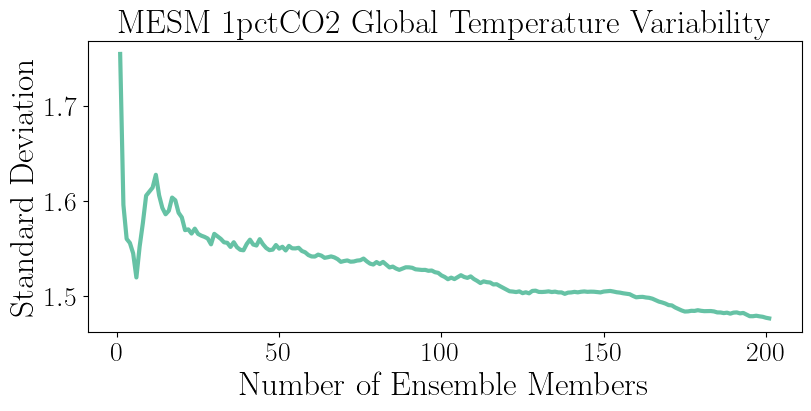

In [122]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.plot(np.arange(1,len(rzs)+1),st_dev,lw=3,c=utils_general.brewer2_light(0))
ax.set_title('MESM 1pctCO2 Global Temperature Variability',fontsize=24)
ax.set_ylabel('Standard Deviation',fontsize=24)
ax.set_xlabel('Number of Ensemble Members',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('MESM_variability.png',dpi=500)

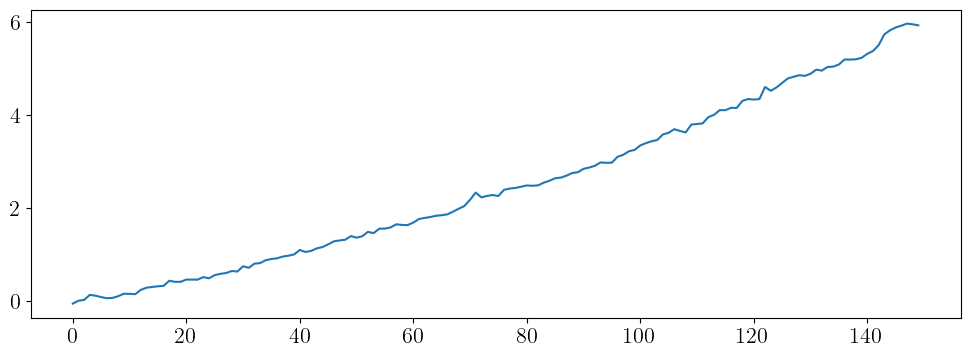

In [69]:
plt.plot(global_temp_annual_ds)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)
ax.plot(m,error,lw=3,c=utils_general.brewer2_light(0))
ax.set_title('Exp. Fit Emulator Error',fontsize=24)
ax.set_ylabel('Error Magnitude',fontsize=24)
ax.set_xlabel('Number of Modes',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('MESM_5.png',dpi=500)

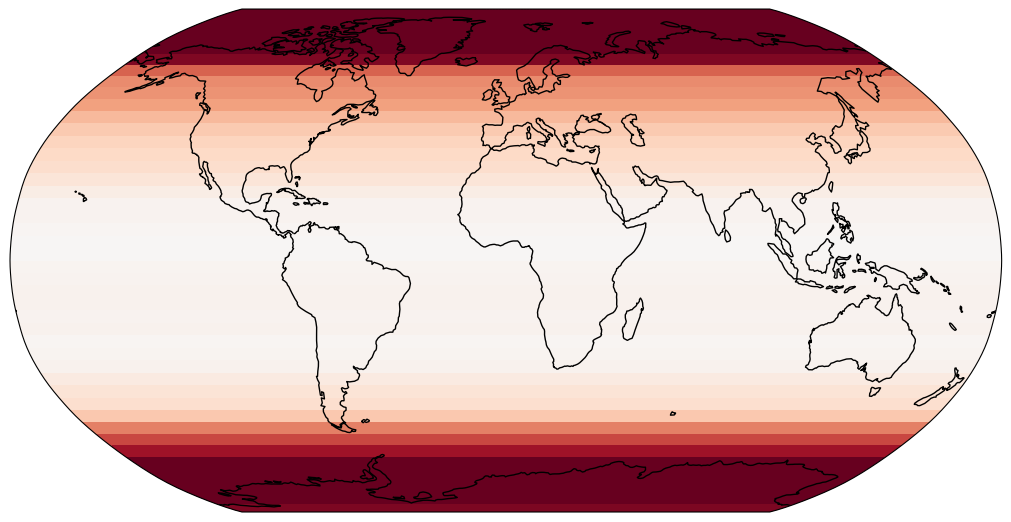

In [122]:
import matplotlib as mpl
import cartopy.crs as ccrs

data = (zonal_temp_annual_ds).sel(time = slice(1990, 1999)).mean(dim = 'time')

lon = np.linspace(0, 360, 360)  # or np.linspace(-180, 180, 360) for a different range
lon2d, lat2d = np.meshgrid(lon, zonal_temp_annual_ds.lat)

data_broadcast = np.tile(data.values[:, np.newaxis], (1, len(lon)))
extremes = (0, 9)
norm = plt.Normalize(*extremes)
cmap = mpl.cm.RdBu_r
fig, ax = plt.subplots(figsize = [10,6], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)
im = ax.pcolormesh(lon2d, lat2d, data_broadcast, transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
ax.coastlines()
plt.savefig('tempfig.png',dpi=500)

## Zonal data

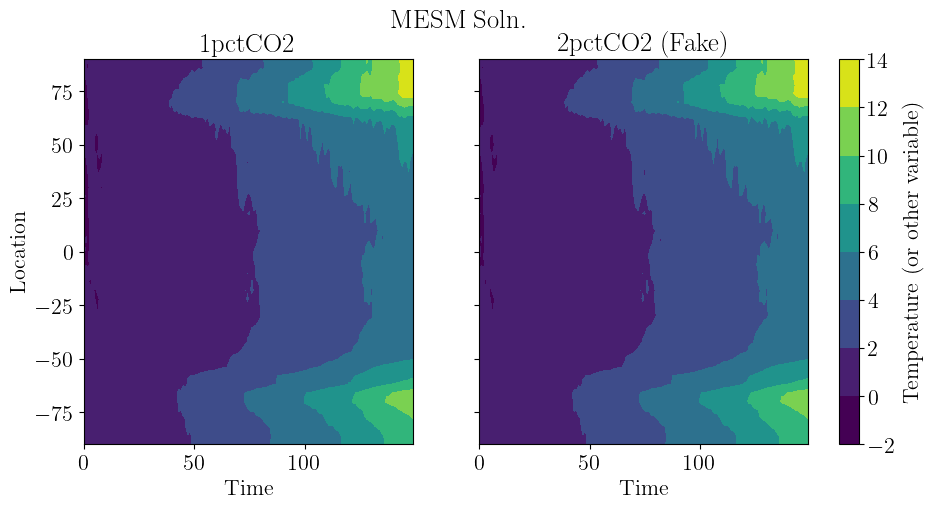

In [5]:
T_zonal = zonal_temp_annual_ds.values.T
g_zonal, a_zonal = utils_general.calc_modes(T_zonal)
F = forcing_ds
t = np.arange(len(F))
x = zonal_temp_annual_ds.lat.values
t_mesh, x_mesh = np.meshgrid(t, x)

T_plot = {'1pctCO2':T_zonal,'2pctCO2 (Fake)':T_zonal}
F_plot = {'1pctCO2':F,'2pctCO2 (Fake)':F}
experiments = ['1pctCO2','2pctCO2 (Fake)']
utils_general.plot_2D(T_plot, t_mesh, x_mesh, experiments, 'MESM Soln.')

#### Method 2: Learn L

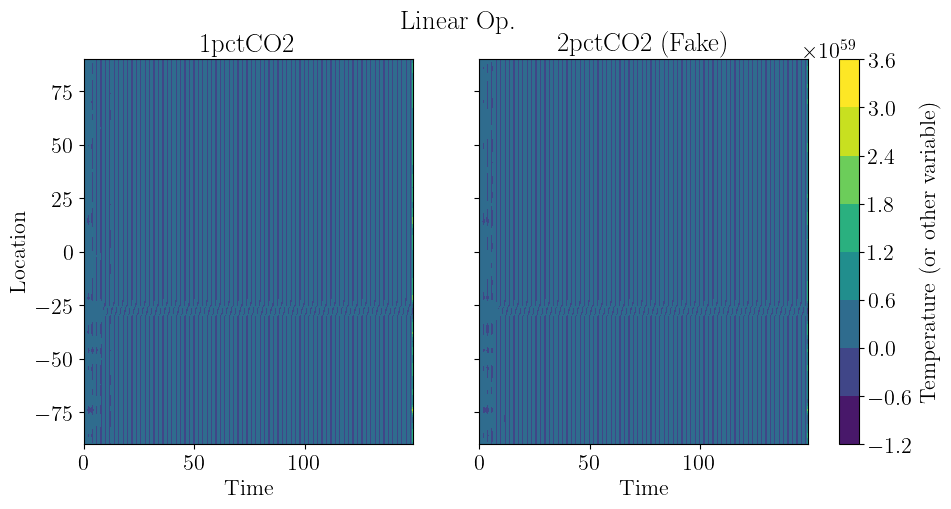

In [12]:
L = utils_general.calc_L_direct_2D(T_zonal, F, t, modal=True, g=g_zonal)
T_est = utils_general.reconstruct_T_2D(F, T_zonal, L, 0, 1, None)
T_L_plot = {'1pctCO2':T_est,'2pctCO2 (Fake)':T_est}
utils_general.plot_2D(T_L_plot, t_mesh, x_mesh, experiments, 'Linear Op.')

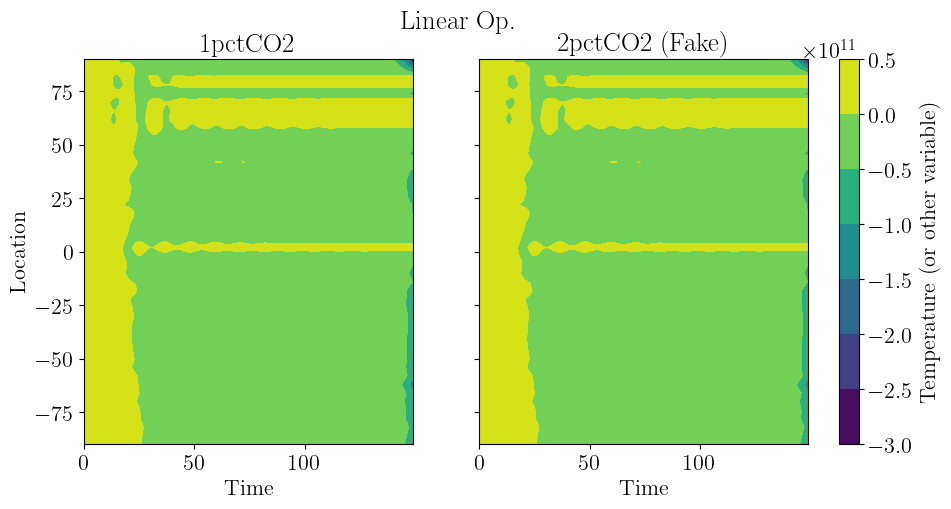

In [6]:
L = utils_general.calc_L_direct_2D(T_zonal, F, t)
T_est = utils_general.reconstruct_T_2D(F, T_zonal, L, 0, 1, None)
T_L_plot = {'1pctCO2':T_est,'2pctCO2 (Fake)':T_est}
utils_general.plot_2D(T_L_plot, t_mesh, x_mesh, experiments, 'Linear Op.')

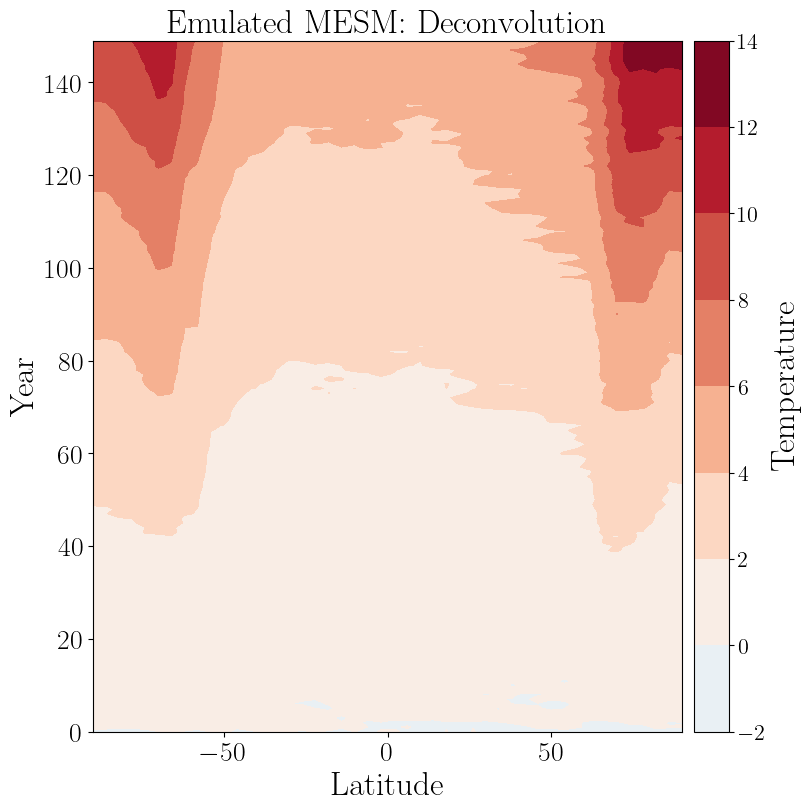

In [40]:
import matplotlib as mpl
cmap = mpl.cm.RdBu_r
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)
extremes = (-14, 14)
norm = plt.Normalize(*extremes)
cf = ax.contourf(x_mesh, t_mesh, T_est_deconv,cmap=cmap,norm=norm)
ax.set_title('Emulated MESM: Deconvolution',fontsize=24)
ax.set_ylabel('Year',fontsize=24)
ax.set_xlabel('Latitude',fontsize=24)


cbar = fig.colorbar(cf, cmap=cmap,ax=ax, orientation='vertical', fraction=0.1, pad=0.02)
cbar.set_label('Temperature',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('MESM_3.png',dpi=500)

In [41]:
np.shape(G_deconv)

(46, 150)

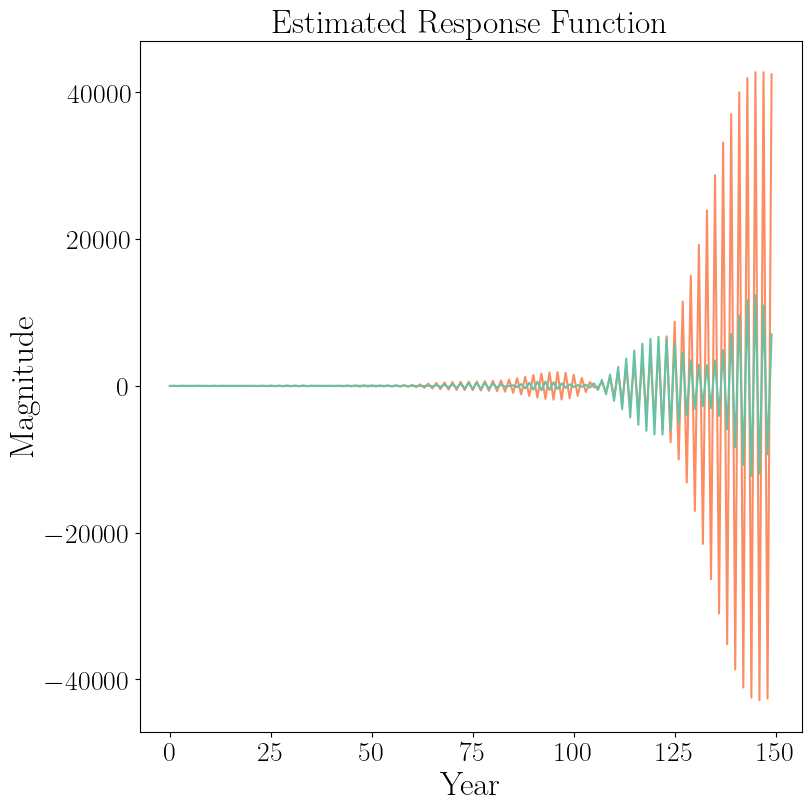

In [46]:
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)
ax.plot(G_deconv[1,:],c=utils_general.brewer2_light(1), label='')
ax.plot(G_deconv[0,:],c=utils_general.brewer2_light(0))
ax.set_title('Estimated Response Function',fontsize=24)
ax.set_ylabel('Magnitude',fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('MESM_4.png',dpi=500)

### Method 3: Deconvolution

In [38]:
from scipy.linalg import toeplitz
G_deconv = utils_general.calc_G_deconv_2D(T_zonal, F, dt=1)
F_toeplitz = toeplitz(F, np.zeros_like(F))
T_est_deconv = (G_deconv) @ F_toeplitz.T

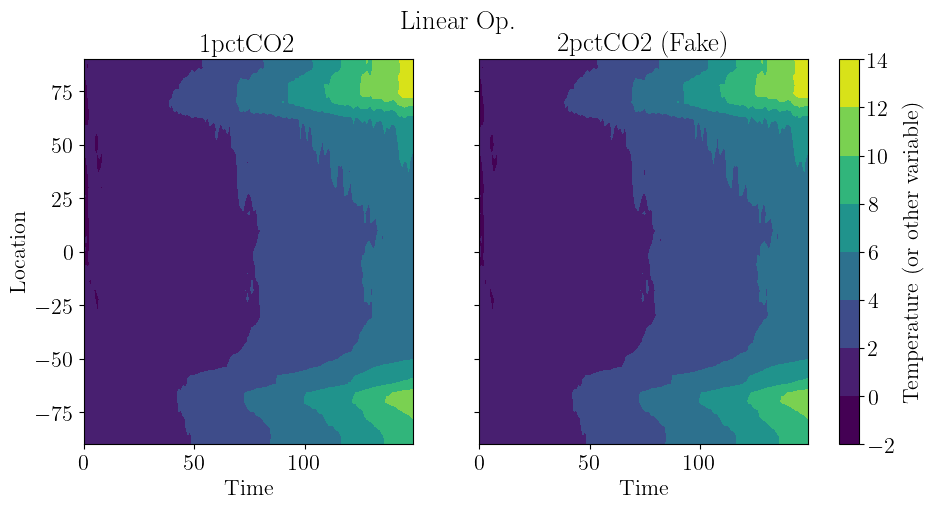

In [51]:
T_deconv_plot = {'1pctCO2':T_est_deconv,'2pctCO2 (Fake)':T_est_deconv}
utils_general.plot_2D(T_deconv_plot, t_mesh, x_mesh, experiments, 'Deconvolution')

In [59]:
error = np.zeros(10)
error[0] = 245.7594333019724 # m = 1
error[1] = 312.9459000819214 # m = 2
error[2] = 161.8550077064254 # m = 3
error[3] = 300.62021796868834 # m = 4
error[4] = 245.3358320877189 # m = 5
error[5] = 371.31643499165864 # m = 6
error[6] = 404.2800068455928 # m = 7
error[7] = 392.8985048794447 # m = 8
error[8] = 392.04592431552686 # m = 9
error[9] = 434.10568509240693 # m = 10
m = np.arange(1,11)

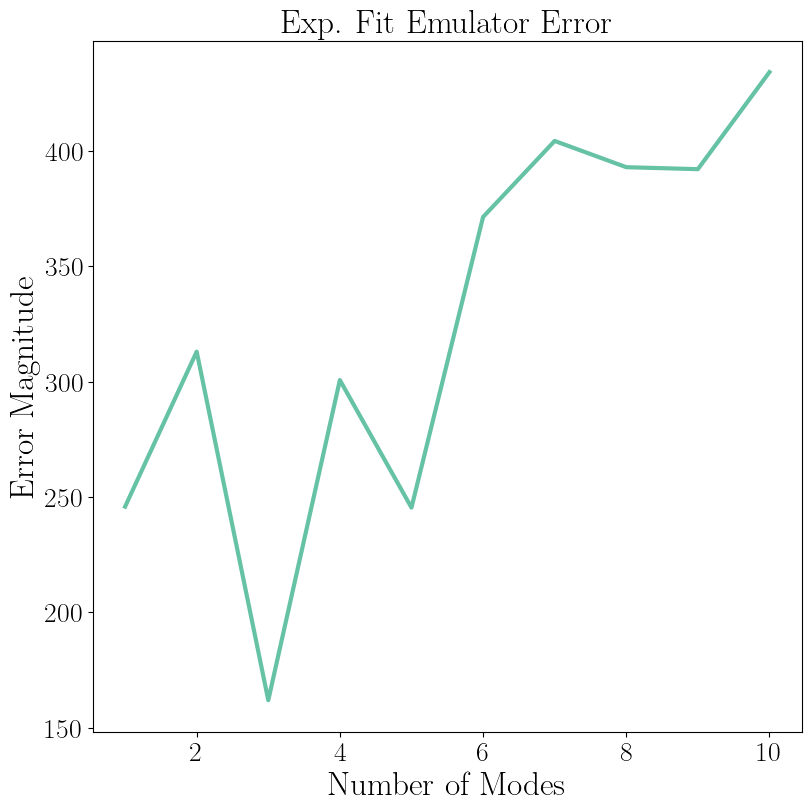

In [62]:
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)
ax.plot(m,error,lw=3,c=utils_general.brewer2_light(0))
ax.set_title('Exp. Fit Emulator Error',fontsize=24)
ax.set_ylabel('Error Magnitude',fontsize=24)
ax.set_xlabel('Number of Modes',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('MESM_5.png',dpi=500)

In [55]:
from scipy.optimize import minimize
m, k = 10, len(T_zonal)
initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

gamma = np.ones(k)

# Constraint 2: Non-negativity (G[i] >= 0)
#def nonnegativity_constraint(G):
#    return G  # Each element of G must be >= 0

# Combine constraints
#constraints = [
#    {"type": "ineq", "fun": nonnegativity_constraint},  # Non-negativity
#]

res = minimize(utils_general.opt_v_lam_2D,
                        initial_params,
                        args=(T_zonal, F, t, m, 1, gamma),
                        method='L-BFGS-B',
                        bounds=bounds)
G_fit = utils_general.apply_v_lam_2D(res.x, t, m, gamma, 1)

434.10568509240693


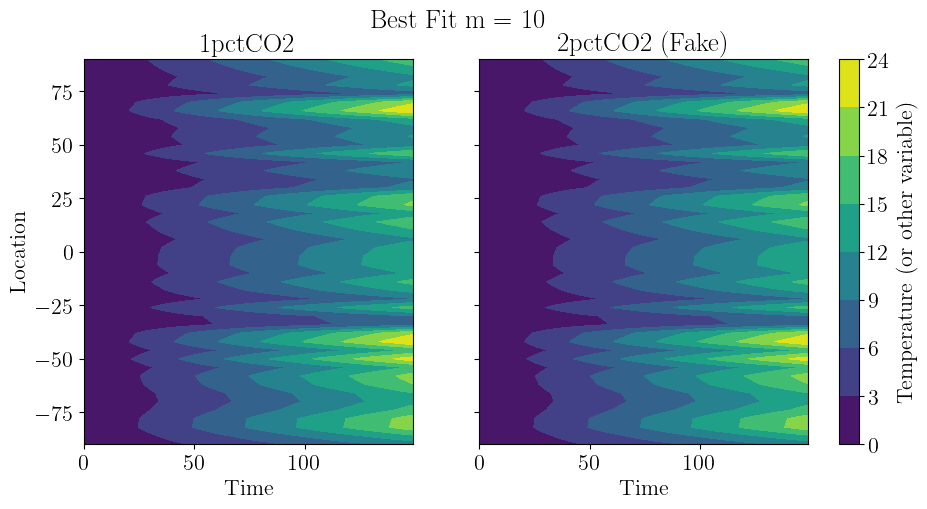

In [56]:
T_est_fit = (G_fit) @ F_toeplitz.T
T_fit_plot = {'1pctCO2':T_est_fit,'2pctCO2 (Fake)':T_est_fit}
print(np.linalg.norm(T_zonal - T_est_fit))
utils_general.plot_2D(T_fit_plot, t_mesh, x_mesh, experiments, f'Best Fit m = {m}')

In [68]:
m, k = 2, len(T_zonal)
initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

gamma = np.ones(k)

res = minimize(utils_general.opt_v_lam_2D,
                        initial_params,
                        args=(T_zonal, F, t, m, 1, gamma),
                        method='L-BFGS-B',
                        bounds=bounds)
G_fit = utils_general.apply_v_lam_2D(res.x, t, m, gamma, 1)

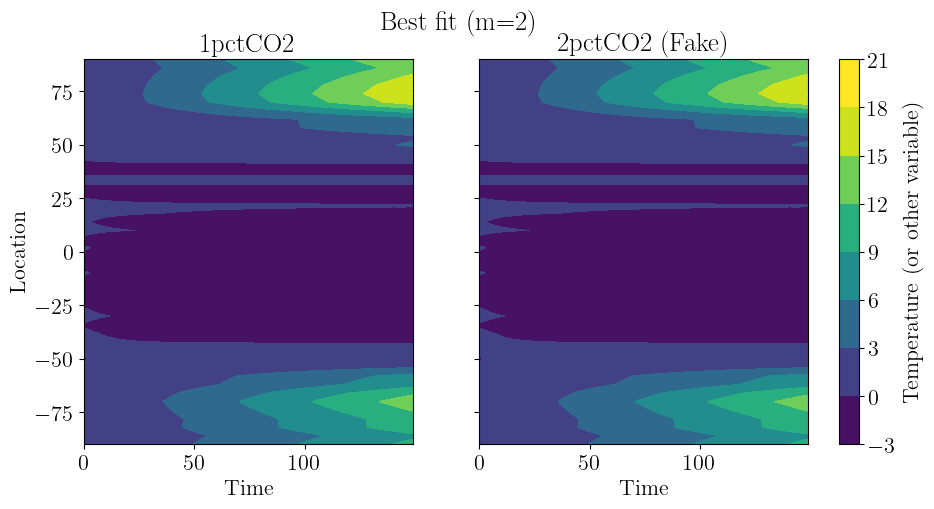

In [69]:
T_est_fit = (G_fit) @ F_toeplitz.T
T_fit_plot = {'1pctCO2':T_est_fit,'2pctCO2 (Fake)':T_est_fit}
utils_general.plot_2D(T_fit_plot, t_mesh, x_mesh, experiments, 'Best fit (m=2)')

## Global data

In [13]:
global_temp_ds = np.loadtxt(f'{global_temp_path}/dt2m_ascii_1-150.2001.23.txt', dtype=float, usecols=1)



In [37]:
T = global_temp_ds*15
F = forcing_ds
t = np.arange(len(T))

### Method 2: Learn L

2.8209383068402003


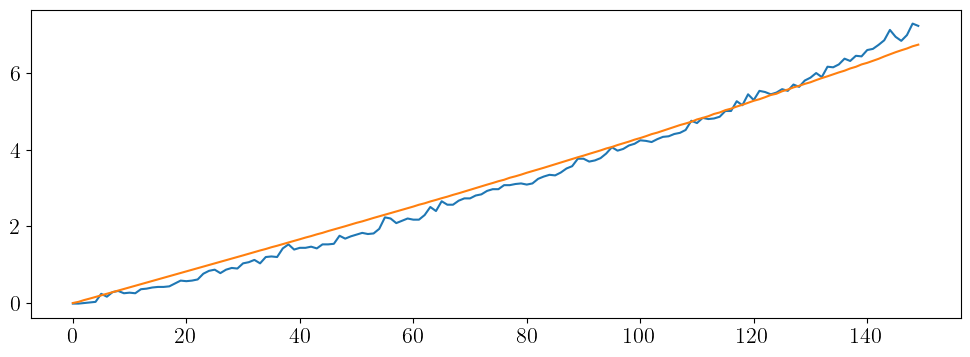

In [39]:
L = utils_general.calc_L_direct_1D(T, F, t, (0,len(t)), 1, 1, modal=False, g=None)
T_est_raw = utils_general.reconstruct_T(F, 1, t, L, 0, 1)

print(np.linalg.norm(T - T_est_raw))
plt.plot(T)
plt.plot(T_est_raw)

### Method 3: Deconvolution

8.547858187172181e-11


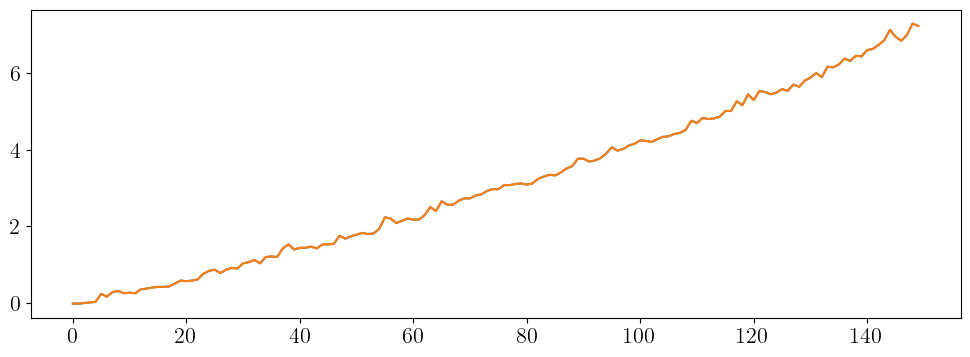

In [41]:
from scipy.linalg import toeplitz
G_deconv = utils_general.calc_G_deconv_2D(T, F, dt=1)

F_toeplitz = toeplitz(F, np.zeros_like(F))
T_est_deconv = (G_deconv) @ F_toeplitz.T

print(np.linalg.norm(T - T_est_deconv))
plt.plot(T)
plt.plot(T_est_deconv)

### Method 4: Best fit

In [43]:
from scipy.optimize import minimize
initial_guess = np.array([1, 1])
t_range = np.arange(t[-1] - t[0] + 1)
res_raw = minimize(utils_general.opt_h_lam_1D,
                                  initial_guess,
                                  args=(T, F, t_range, 1))

G_fit = utils_general.apply_response_1D(res_raw.x, t_range)

1.5058312117791228


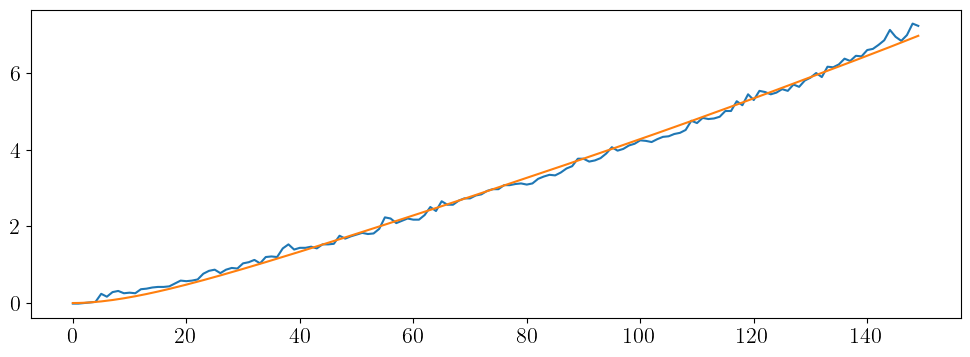

In [45]:
T_est_fit = (G_fit) @ F_toeplitz.T
print(np.linalg.norm(T - T_est_fit))
plt.plot(T)
plt.plot(T_est_fit.T)

## Alternate approach: Use best fit as a prior on G for deconvolution/finding the linear operator

### Linear operator w/ prior

In [ ]:
# Define the objective function
lambda_reg = 0.5
def objective_L(L):
  T_guess = utils_general.reconstruct_T(F, 1, t, L, 0, 1)
  fidelity = np.linalg.norm(T_guess - T)**2
  regularization = lambda_reg * np.linalg.norm(L - L_prior)**2
  return fidelity + regularization

# Initial guess for G
L_init = np.random.rand(1)

# Solve using gradient-based optimization
result = minimize(objective_L, L_init, method='L-BFGS-B')
L = result.x

### Deconvolution w/ prior

In [73]:
G_prior = G_fit
lambda_reg = 100000             # Regularization strength
F_toep = F_toeplitz

# Solve for G using the closed-form solution
I = np.eye(F_toep.shape[1])       # Identity matrix (size 50x50)
FTF = F_toep.T @ F                # Compute F^T * F
FTT = F_toep.T @ T                # Compute F^T * T

# Regularized least-squares solution
G_reg = np.linalg.solve(FTF + lambda_reg * I, FTT + lambda_reg * G_prior)

16.3707916586658


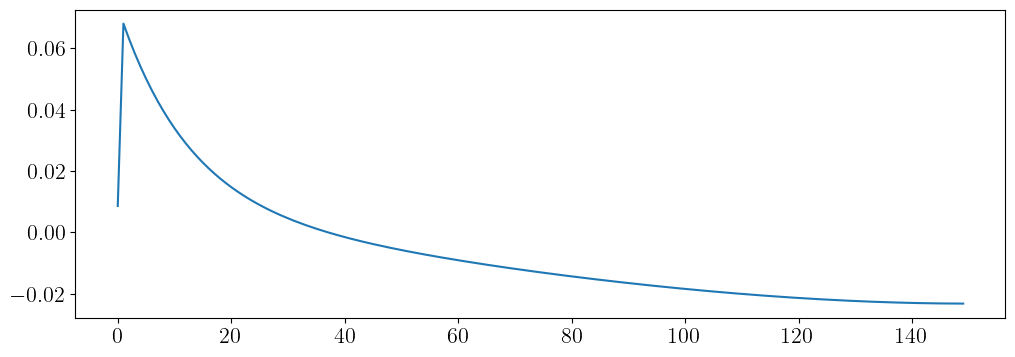

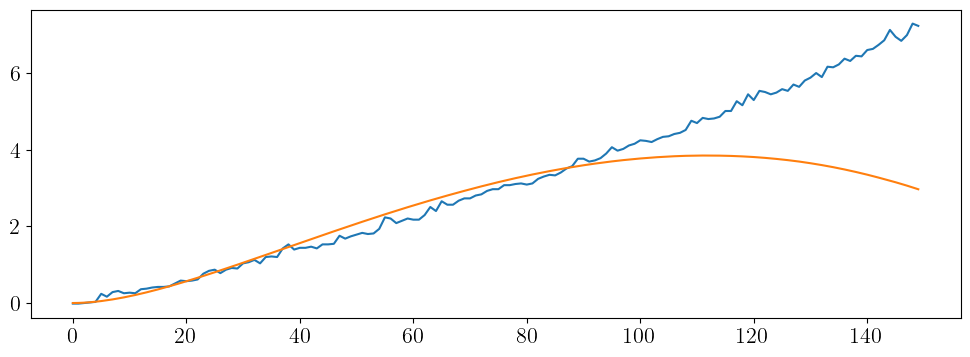

In [74]:
plt.plot(G_reg)
T_est_reg = (G_reg) @ F_toeplitz.T

print(np.linalg.norm(T - T_est_reg))
plt.figure()
plt.plot(T)
plt.plot(T_est_reg)

In [89]:
# Define the objective function
lambda_reg = 0.5
def objective(G):
  fidelity = np.linalg.norm(F @ G - T)**2
  regularization = lambda_reg * np.linalg.norm(G - G_prior)**2
  return fidelity + regularization

# Initial guess for G
G_init = np.random.rand(F_toep.shape[1])

# Solve using gradient-based optimization
result = minimize(objective, G_init, method='L-BFGS-B')
G_opt = result.x

5.508287381232798


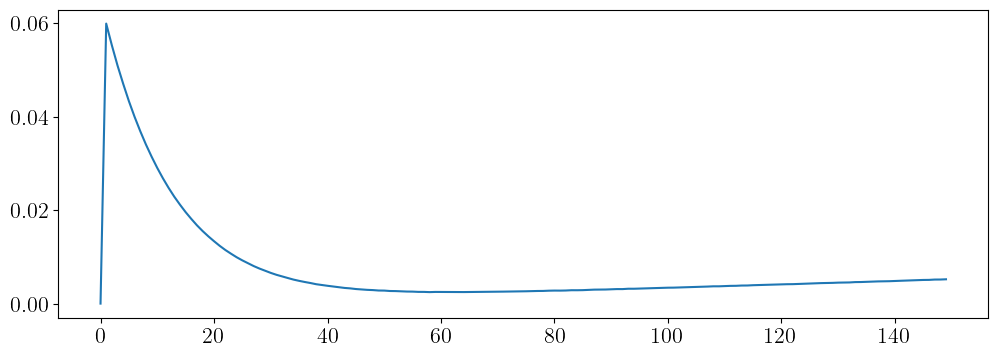

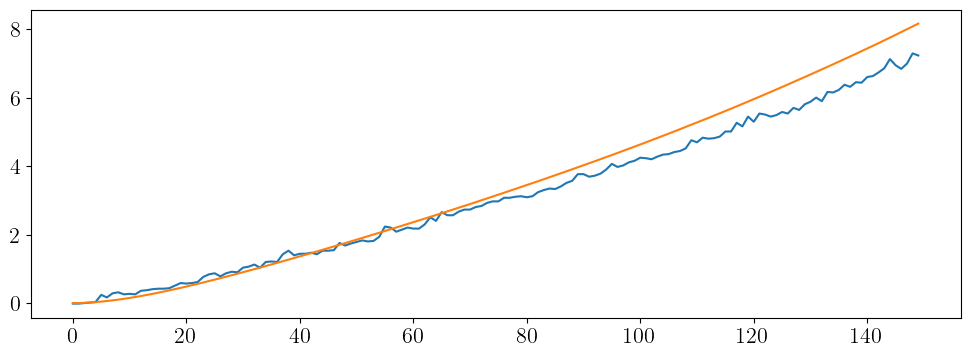

In [90]:
plt.plot(G_opt)
T_est_opt = (G_opt) @ F_toeplitz.T

print(np.linalg.norm(T - T_est_opt))
plt.figure()
plt.plot(T)
plt.plot(T_est_opt)

In [117]:
lambda_reg = 0.6

# Constraint 1: Monotonicity (G[i] >= G[i+1] for i >= 2)
def monotonicity_constraint(G):
    return G[1:] - G[:-1]  # Returns vector of differences (G[i+1] - G[i] >= 0)

# Constraint 2: Non-negativity (G[i] >= 0)
def nonnegativity_constraint(G):
    return G  # Each element of G must be >= 0

# Combine constraints
constraints = [
    {"type": "ineq", "fun": monotonicity_constraint},  # Monotonicity
    {"type": "ineq", "fun": nonnegativity_constraint},  # Non-negativity
]

# Initial guess for G
G_init = np.random.rand(F_toep.shape[1])

# Solve using gradient-based optimization
result = minimize(objective, G_init, constraints=constraints, method='SLSQP')
G_opt = result.x

1859.3240759810092


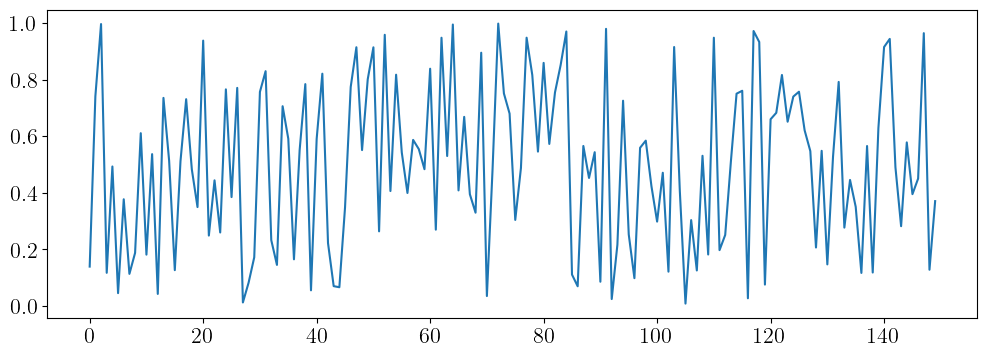

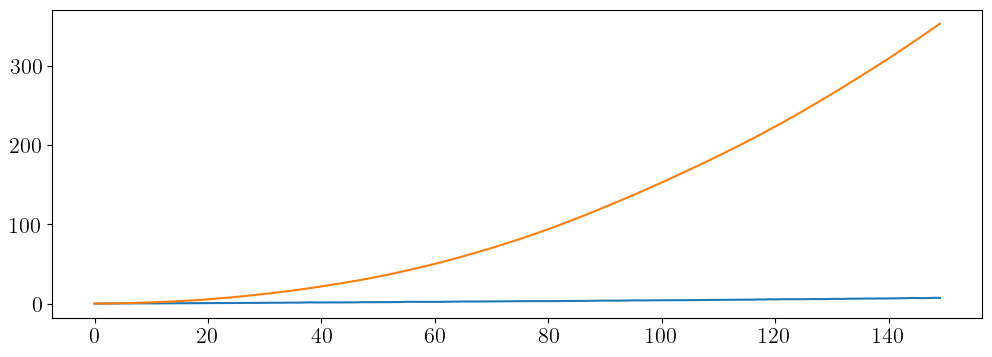

In [118]:
plt.plot(G_opt)
T_est_opt = (G_opt) @ F_toeplitz.T

print(np.linalg.norm(T - T_est_opt))
plt.figure()
plt.plot(T)
plt.plot(T_est_opt)